In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
import matplotlib.patches as patches
import matplotlib.lines as mlines

In [52]:
# energy specific fuel prices are not
SCENARIO = "static" # "static" | "dynamic"

In [53]:
DATA = Path("..","data","processed", SCENARIO)
FIGURES = Path("..","figures","netload", SCENARIO) 
SECTORS = ["E", "H", "EH"]
PRICES = ["high", "mid", "low", "vlow"]
EMISSIONS = ["20", "35", "50"]
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical\nand Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very\nLow",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [54]:
def get_scenario_name(emission: str, sector: Optional[str] = None, price: Optional[str] = None) -> str:
    if not (sector or price):
        return f"er{emission}"
    else:
        return f"{sector}dr-{price}-er{emission}" 

In [55]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    scenario = get_scenario_name(emission=emission, sector=sector, price=price)
    p = Path(DATA, scenario, "dataframe", f"{result}.csv")
    return pd.read_csv(p)

In [56]:
def get_ldc(emission: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.Series:
    scenario = get_scenario_name(emission=emission, sector=sector, price=price)
    df = get_dataframe(emission=emission, sector=sector, price=price, result="peakiness")
    return df[["Net_Load_MW"]].rename(columns={"Net_Load_MW":scenario}).squeeze().sort_values(ascending=False)

In [57]:
def get_data() -> dict[str,pd.DataFrame]:
    data = {}
    for emission in EMISSIONS:
        dfs = []
        dfs.append(get_ldc(emission).to_frame(name="base"))
        for sector, price in product(SECTORS, PRICES):
            df = get_ldc(emission, sector, price).to_frame()
            dfs.append(df)
        data[f"er{emission}"] = pd.concat(dfs, axis=1)
    return data

In [58]:
def generate_ldc(
    emission: str, include_title: bool = True, **kwargs
) -> tuple[plt.figure, plt.axes]:
    data = get_data()

    ncols = 2
    nrows = 1

    color_map = {
        "base": "k",
        "Edr": "tab:purple",
        "Hdr": "tab:orange",
        "EHdr": "tab:green",
    }

    linestyle_map = {
        "base": "-",
        "high": "-",
        "mid": "--",
        "low": "-.",
        "vlow": ":",
    }

    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))

    title = kwargs.get("title", "")
    if title:
        fig.suptitle(title, fontsize=20)

    df = data[emission]

    upper = df.max().max()
    lower = df.max().min()

    for col in df.columns:
        if col == "base":
            sector = "base"
            price = "base"
            label = "No DR"
        else:
            sector = col.split("-")[0]
            price = col.split("-")[1]
            label = f"{sector}-{price}"

        color = color_map[sector]
        linestyle = linestyle_map[price]

        df[col].plot(ax=axs[0], label=label, color=color, linestyle=linestyle)
        df[col].plot(
            ax=axs[1],
            xlim=(0, 100),
            ylim=(lower - 4000, upper + 2000),
            label=label,
            color=color,
            linestyle=linestyle,
        )

    rectangle = patches.Rectangle(
        (-300, lower - 4000),  # (x, y) of bottom-left corner
        600,  # Width of the rectangle
        (upper + 2000) - (lower - 4000),  # Height of the rectangle
        linewidth=2,
        edgecolor="red",
        facecolor="none",
        zorder=99,
    )
    axs[0].add_patch(rectangle)

    handles, labels = axs[0].get_legend_handles_labels()

    # for custom linewidth
    legend_handles = [
        mlines.Line2D(
            [],
            [],
            color=handle.get_color(),
            linewidth=2,
            linestyle=handle.get_linestyle(),
        )
        for handle in handles
    ]

    fig.legend(
        legend_handles,
        labels,
        loc="center left",
        bbox_to_anchor=(1, 0.5),  # right side
        ncol=1,
        frameon=False,
        fontsize=14,
    )
    
    axs[0].tick_params(axis="both", labelsize=12)
    axs[1].tick_params(axis="both", labelsize=12)

    if include_title:
        fig.suptitle(
            f"{emission[-2:]}% Emission Reduction Net Load Duration Curve", fontsize=20
        )
    fig.supxlabel("Hour of Year", fontsize=18)
    fig.supylabel("Net Load (MW)", fontsize=18)

    fig.tight_layout(rect=[0, 0, 1, 0.99])

    return fig, axs

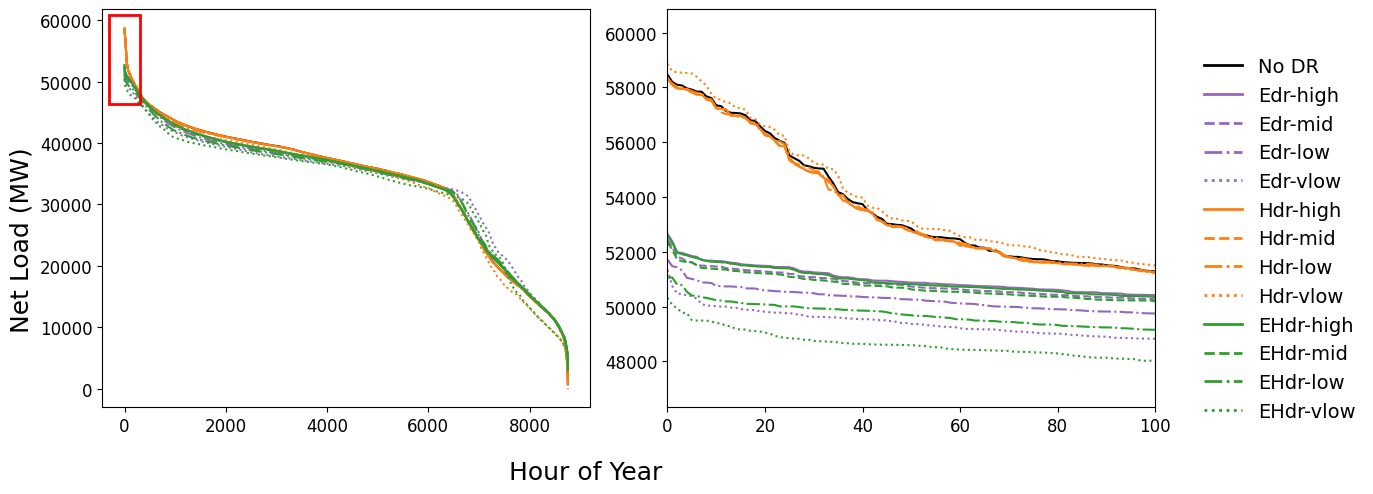

In [59]:
fig, _ = generate_ldc("er20", include_title=False)
fig.savefig(Path(FIGURES, "er20.png"), bbox_inches="tight")

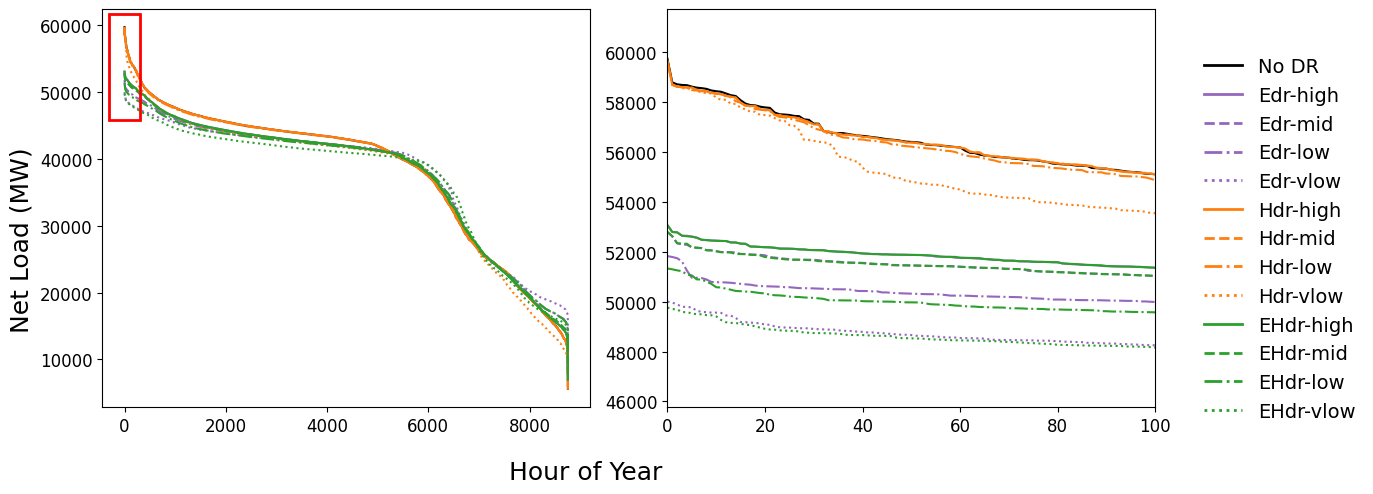

In [60]:
fig, _ = generate_ldc("er35", include_title=False)
fig.savefig(Path(FIGURES, "er35.png"), bbox_inches="tight")

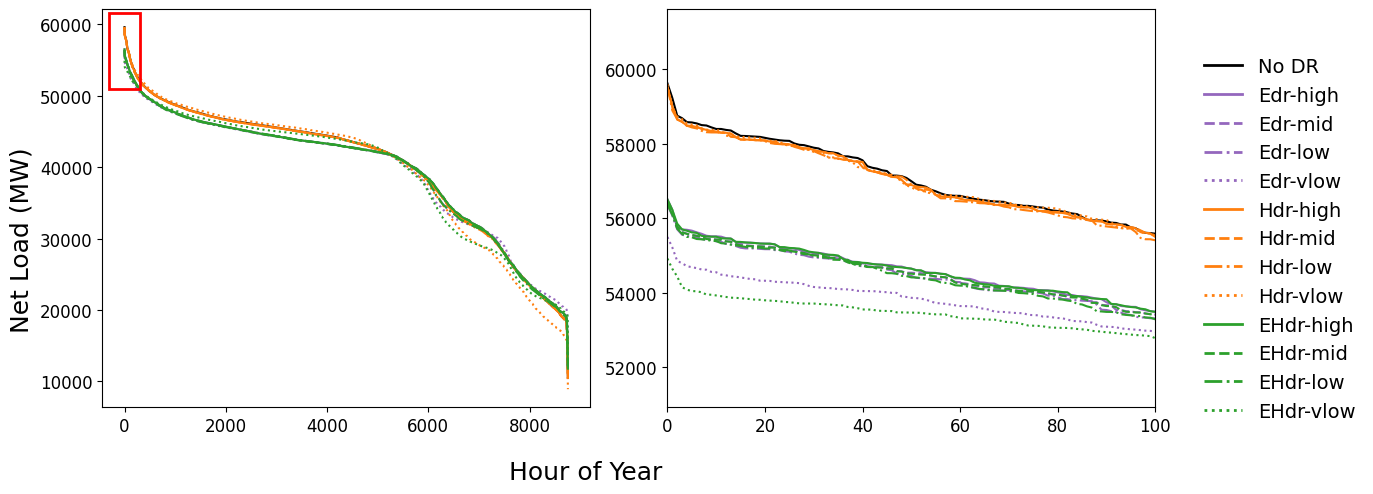

In [61]:
fig, _ = generate_ldc("er50", include_title=False)
fig.savefig(Path(FIGURES, "er50.png"), bbox_inches="tight")